#PhlyGreen Tutorial 

Import packages

In [1]:
import sys
sys.path.append('../')
import PhlyGreen as pg
import numpy as np
import matplotlib.pyplot as plt

Create instances of subsystems. Each one of those requires an Aircraft object as argument. By passing (None) as argument, we are creating empty objects (for the moment).

In [2]:
powertrain = pg.Systems.Powertrain.Powertrain(None)
structures = pg.Systems.Structures.Structures(None)
aerodynamics = pg.Systems.Aerodynamics.Aerodynamics(None)
performance = pg.Performance.Performance(None)
mission = pg.Mission.Mission(None)
weight = pg.Weight.Weight(None)
constraint = pg.Constraint.Constraint(None)
welltowake = pg.WellToWake.WellToWake(None)
climateimpact = pg.ClimateImpact.ClimateImpact(None)

Create instance of Aircraft object.

In [3]:
myaircraft = pg.Aircraft(powertrain, structures, aerodynamics, performance, mission, weight, constraint, welltowake, climateimpact)

Create the connections with its subsystems.

In [4]:
powertrain.aircraft = myaircraft
structures.aircraft = myaircraft
aerodynamics.aircraft = myaircraft
mission.aircraft = myaircraft
performance.aircraft = myaircraft
weight.aircraft = myaircraft
constraint.aircraft = myaircraft
welltowake.aircraft = myaircraft
climateimpact.aircraft = myaircraft

Define input dictionaries

Constraints ordering:
[0] : cruise,
[1] : take-off,
[2] : climb,
[3] : turn,
[4] : ceiling,
[5] : acceleration,
[6] : landing 

In [5]:
ConstraintsInput = {'speed': np.array([0.4, 140, 170, 210, 0.5, 0.35, 104.]) ,
                    'speedtype': ['Mach','KCAS','KCAS','KCAS','Mach','Mach','KCAS']   ,
                    'beta': np.array([0.95,0.985,0.97, 0.9, 0.8, 0.9, None])   ,
                    'altitude': np.array([8000., 100., 6000., 5000, 9500., 6000, 500.]),
                    'load factor': np.array([1., None, 1., 1.1, 1., 1., None]),
                    'DISA': 0, 
                    'kTO': 1.2,
                    'sTO': 950,
                    'OEI Climb Gradient': 0.021,
                    'Rate of Climb': 5,  #5m/s ~= 1000 ft/min, 7.6 ~= 1500 ft/min
                    'ht': 0.5,
                    'M1': 0.3,
                    'M2': 0.4,
                    'DTAcceleration': 180}

In [6]:
MissionInput = {'Range Mission': 750,  #nautical miles
                'Range Diversion': 220,  #nautical miles
                'Beta start': 0.985,
                'Payload Weight': 4560,  #Kg
                'Crew Weight': 500}  #Kg

In [7]:
MissionStages = {'Climb1': {'type': 'ConstantRateClimb', 'input': {'CB': 0.12, 'Speed': 77, 'StartAltitude': 100, 'EndAltitude': 1500}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Climb2': {'type': 'ConstantRateClimb', 'input': {'CB': 0.06, 'Speed': 110, 'StartAltitude': 1500, 'EndAltitude': 4500}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Climb3': {'type': 'ConstantRateClimb', 'input': {'CB': 0.05, 'Speed': 110, 'StartAltitude': 4500, 'EndAltitude': 7000}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Cruise': {'type': 'ConstantMachCruise', 'input':{ 'Mach': 0.45, 'Altitude': 7000}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Descent1': {'type': 'ConstantRateDescent', 'input':{'CB': -0.04, 'Speed': 90, 'StartAltitude': 7000, 'EndAltitude': 200}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }}}

DiversionStages = {'Climb1': {'type': 'ConstantRateClimb', 'input': {'CB': 0.06, 'Speed': 110, 'StartAltitude': 200, 'EndAltitude': 3100}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Cruise': {'type': 'ConstantMachCruise', 'input':{ 'Mach': 0.2, 'Altitude': 3100}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0}},
                 'Descent1': {'type': 'ConstantRateDescent', 'input':{'CB': -0.04, 'Speed': 90, 'StartAltitude': 3100, 'EndAltitude': 200}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }}}

In [8]:
EnergyInput = {'Ef': 43.5*10**6,
                   'Eta Gas Turbine Model': 'PW127',
                   #'Eta Gas Turbine': 0.22,
                   'Eta Gearbox': 0.96,
                   'Eta Propulsive Model': 'constant',
                   'Eta Propulsive': 0.75,
                   'Specific Power Powertrain': [3900,0]  # W/Kg
                   }

In [9]:
AerodynamicsInput = {'NumericalPolar': {'type': 'ATR42'}}

In [10]:
ClimateImpactInput = {'H': 100, 'N':497*50, 'Y':30, 'EINOx_model':'GasTurb'}

Import input dictionaries

In [11]:
myaircraft.ConstraintsInput = ConstraintsInput
myaircraft.AerodynamicsInput = AerodynamicsInput
myaircraft.MissionInput = MissionInput
myaircraft.MissionStages = MissionStages
myaircraft.DiversionStages = DiversionStages
myaircraft.EnergyInput = EnergyInput
myaircraft.ClimateImpactInput = ClimateImpactInput

Set aircraft power configuration

In [12]:
myaircraft.Configuration = 'Traditional'

Set inputs

In [13]:
# Initialize Constraint Analysis
myaircraft.constraint.SetInput()

# Initialize Mission profile and Analysis
myaircraft.mission.InitializeProfile()
myaircraft.mission.SetInput()

# Initialize Aerodynamics subsystem
myaircraft.aerodynamics.SetInput()

# Initialize Powertrain
myaircraft.powertrain.SetInput()

# Initialize Weight Estimator
myaircraft.weight.SetInput()

# Initialize Climate Impact Estimator
myaircraft.climateimpact.SetInput()

Either run the Constraint Analysis....

In [14]:
myaircraft.constraint.FindDesignPoint()
print('----------------------------------------')
print('Design W/S: ',myaircraft.DesignWTOoS)
print('Design P/W: ',myaircraft.DesignPW)
print('----------------------------------------')

----------------------------------------
Design W/S:  3328.8528528528527
Design P/W:  168.51352203046332
----------------------------------------


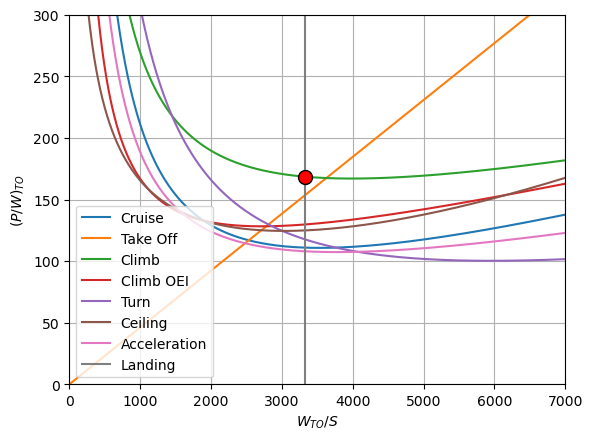

In [15]:
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWCruise, label='Cruise')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWTakeOff, label='Take Off')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWClimb, label='Climb')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWOEI, label='Climb OEI')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWTurn, label='Turn')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWCeiling, label='Ceiling')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWAcceleration, label='Acceleration')
plt.plot(myaircraft.constraint.WTOoSLanding,myaircraft. constraint.PWLanding, label='Landing')
plt.plot(myaircraft.DesignWTOoS, myaircraft.DesignPW, marker='o', markersize = 10, markerfacecolor = 'red', markeredgecolor = 'black')
# plt.plot(performance.WTOoSTorenbeek, performance.PWTorenbeek, label='Torenbeek')
plt.ylim([0, 300])
plt.xlim([0, 7000])
plt.legend()
plt.grid(visible=True)
plt.xlabel('$W_{TO}/S$')
plt.ylabel('$(P/W)_{TO}$')
plt.show()

Run Mission analysis to define the aircraft's masses

In [16]:
myaircraft.weight.WeightEstimation()

Wing surface can be readily estimated as S = WTO/(WTO/S)

In [17]:
myaircraft.WingSurface = myaircraft.weight.WTO / myaircraft.DesignWTOoS * myaircraft.performance.g_acc 

A summary of the preliminary design:

In [18]:
print('----------------------------------------')
print('Fuel mass (trip + altn) [Kg]: ', myaircraft.weight.Wf)
print('Block Fuel mass [Kg]:         ', myaircraft.weight.Wf + myaircraft.weight.final_reserve)
print('Structure [Kg]:               ', myaircraft.weight.WStructure)
print('Powertrain mass [Kg]:         ',myaircraft.weight.WPT)
print('Empty Weight [Kg]:            ', myaircraft.weight.WPT + myaircraft.weight.WStructure + myaircraft.weight.WCrew)
print('Zero Fuel Weight [Kg]:        ', myaircraft.weight.WPT + myaircraft.weight.WStructure + myaircraft.weight.WCrew + myaircraft.weight.WPayload)
print('----------------------------------------')
print('Takeoff Weight [Kg]:          ', myaircraft.weight.WTO)
if myaircraft.WellToTankInput is not None:
    print('Source Energy: ', myaircraft.welltowake.SourceEnergy/1.e6,' MJ')
    print('Psi: ', myaircraft.welltowake.Psi)
print('Wing Surface [m^2]:           ', myaircraft.WingSurface)
print('TakeOff shaft peak power [kW]:      ', myaircraft.mission.TO_PP/1000.)
print('Climb/cruise shaft peak power [kW]: ', myaircraft.mission.Max_PEng/1000.)
print('Sizing phase for thermal powertrain: ', 'Climb/Cruise peak power' if myaircraft.mission.Max_PEng > myaircraft.mission.TO_PP else 'Takeoff peak power'  )
print('----------------------------------------')


----------------------------------------
Fuel mass (trip + altn) [Kg]:  2133.2710778275346
Block Fuel mass [Kg]:          2263.2710778275346
Structure [Kg]:                10377.131056455126
Powertrain mass [Kg]:          1024.617262840593
Empty Weight [Kg]:             11901.748319295719
Zero Fuel Weight [Kg]:         16461.74831929572
----------------------------------------
Takeoff Weight [Kg]:           18724.985998968787
Wing Surface [m^2]:            55.18180609649305
TakeOff shaft peak power [kW]:       3996.007325078313
Climb/cruise shaft peak power [kW]:  3325.9688771073147
Sizing phase for thermal powertrain:  Takeoff peak power
----------------------------------------


Some plots:

In [19]:
times = np.array([])
Ef = np.array([])
beta = np.array([])
for array in mission.integral_solution:
    times = np.concatenate([times, array.t])
    Ef = np.concatenate([Ef, array.y[0]])
    beta = np.concatenate([beta, array.y[1]])

Take-Off Propulsive Power over Takeoff Mass

In [20]:
myaircraft.performance.TakeOff(myaircraft.DesignWTOoS,myaircraft.constraint.ConstraintsBeta[1], myaircraft.constraint.ConstraintsAltitude[1], myaircraft.constraint.kTO, myaircraft.constraint.sTO, myaircraft.constraint.DISA, myaircraft.constraint.ConstraintsSpeed[1], myaircraft.constraint.ConstraintsSpeedtype[1])

153.65125462054286

Maximum mission Propusive Power over Takeoff Mass

In [21]:
max([myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))])

127.88747597863872

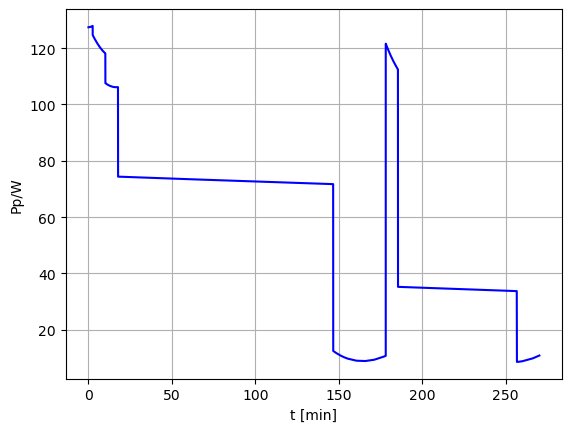

In [22]:
graph_values = []

for t in range(len(times)):
    value_at_t = myaircraft.performance.PoWTO(
        myaircraft.DesignWTOoS,
        beta[t],
        myaircraft.mission.profile.PowerExcess(times[t]),
        1,
        myaircraft.mission.profile.Altitude(times[t]),
        myaircraft.mission.DISA,
        myaircraft.mission.profile.Velocity(times[t]),
        'TAS'
    )

    graph_values.append(value_at_t)

plt.plot(times/60, graph_values, 'b')
# tutte le righe precedenti di questa cella sono equivalenti a:
# plt.plot(times/60,[myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))], 'b')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Pp/W')
plt.show()

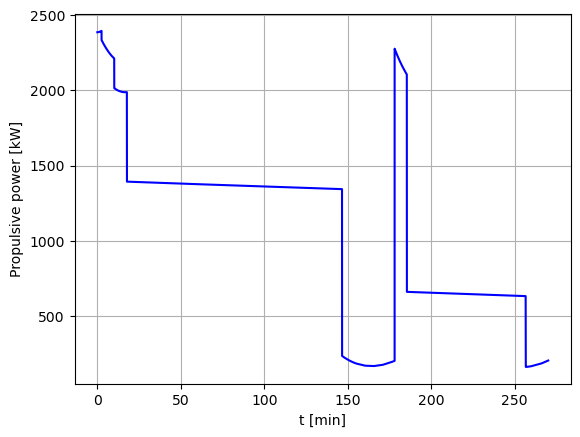

In [23]:
plt.plot(times/60,[(myaircraft.weight.WTO/1000) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))], 'b')
# pwsd[t]= 1e-3*0.5*0.89*(myaircraft.weight.WTO/1000) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Propulsive power [kW]')
plt.show()

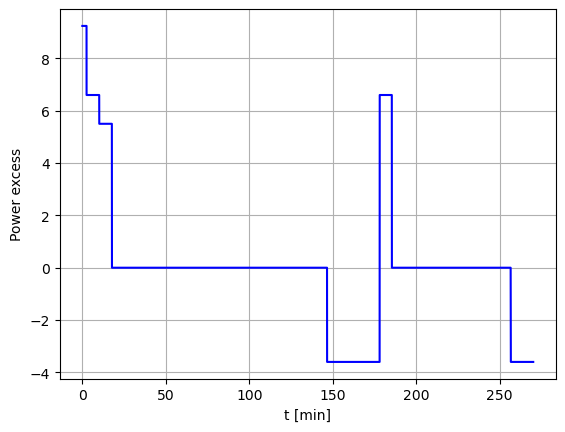

In [24]:
plt.plot(times/60,[myaircraft.mission.profile.PowerExcess(times[t]) for t in range(len(times))], 'b')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Power excess')
plt.show()

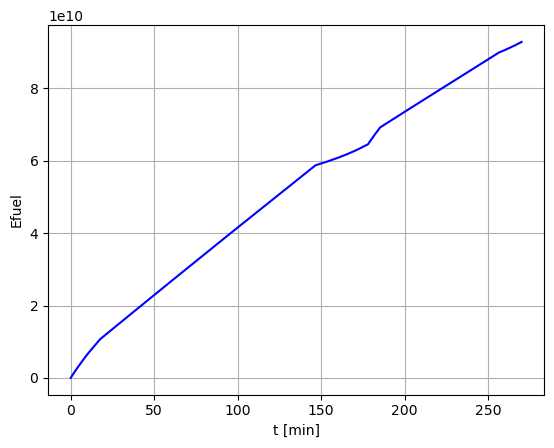

In [25]:
plt.plot(times/60,Ef, 'b')
#plt.plot(myaircraft.mission.profile.Breaks,np.ones(6)*0.05, '*')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Efuel')
plt.show()

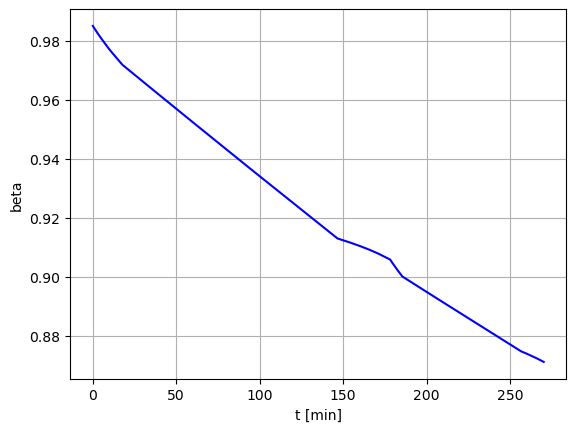

In [26]:
plt.plot(times/60,beta, 'b')
#plt.plot(myaircraft.mission.profile.Breaks,np.ones(6)*0.05, '*')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('beta')
plt.show()

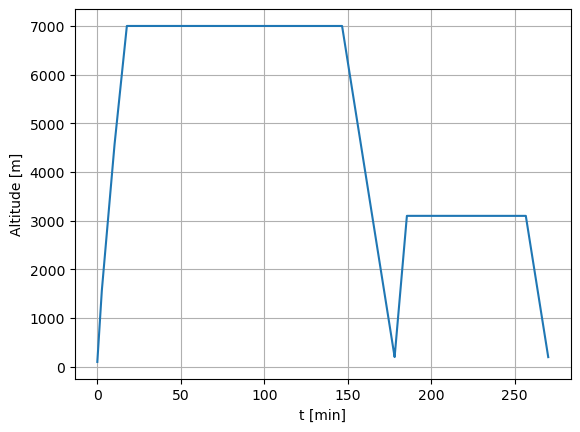

In [27]:
plt.plot(times/60,mission.profile.Altitude(times))
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Altitude [m]')
plt.show()

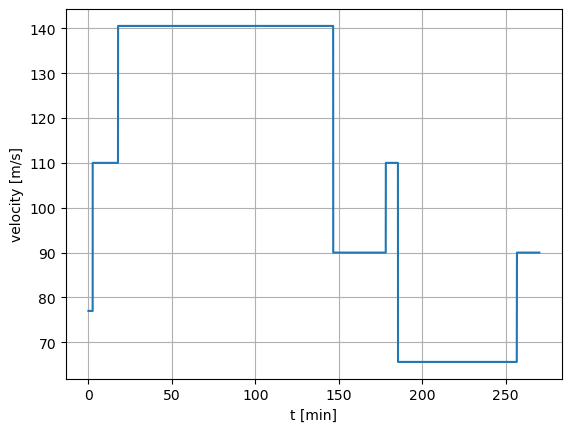

In [28]:
plt.plot(times/60,mission.profile.Velocity(times))
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('velocity [m/s]')
plt.show()

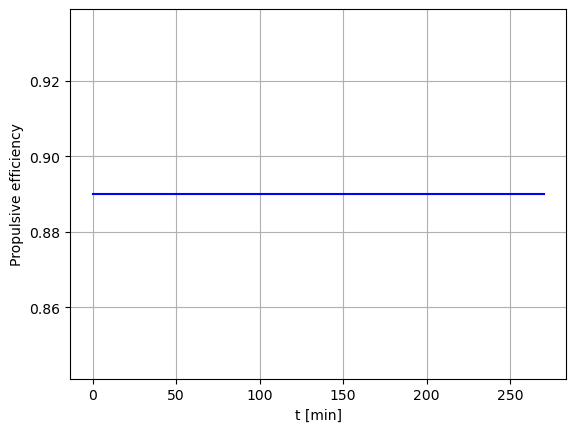

In [29]:
etaPP = np.zeros(len(times))
for t in range(len(times)):
    alt = myaircraft.mission.profile.Altitude(times[t])
    v = myaircraft.mission.profile.Velocity(times[t])
    power = (myaircraft.weight.WTO) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,alt,myaircraft.mission.DISA,v,'TAS')
    etaPP[t]= myaircraft.powertrain.EtaPPpw127Model(alt, v, power)
plt.plot(times/60,etaPP, 'b')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Propulsive efficiency')
plt.show()

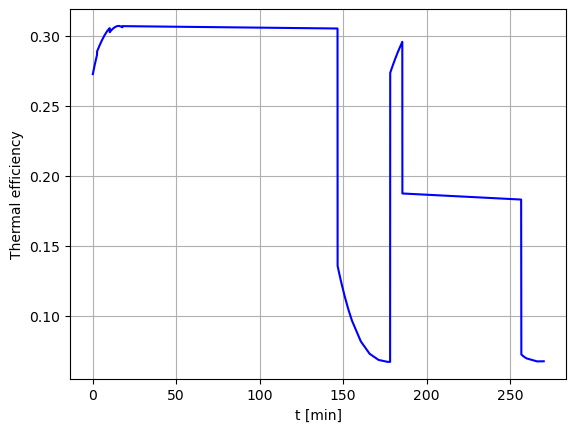

In [30]:
if myaircraft.EnergyInput['Eta Gas Turbine Model'] == 'PW127':
    etaTh = np.zeros(len(times))
    for t in range(len(times)):
        alt = myaircraft.mission.profile.Altitude(times[t])
        v = myaircraft.mission.profile.Velocity(times[t])
        power = (myaircraft.weight.WTO) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,alt,myaircraft.mission.DISA,v,'TAS')
        etaTh[t]= myaircraft.powertrain.EtaGTpw127Model(alt, v, power)
    plt.plot(times/60,etaTh, 'b')
    plt.grid(visible=True)
    plt.xlabel('t [min]')
    plt.ylabel('Thermal efficiency')
    plt.show()

In [31]:
pwsd = np.zeros(len(times))
alt = np.zeros(len(times))
v0 = np.zeros(len(times))
power = np.zeros(len(times))
PowerExcess = np.zeros(len(times))

for t in range(len(times)):
    alt[t] = myaircraft.mission.profile.Altitude(times[t])
    v0[t] = myaircraft.mission.profile.Velocity(times[t])
    power[t] = (myaircraft.weight.WTO) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,alt[t],myaircraft.mission.DISA,v0[t],'TAS')
    pwsd[t]= 1e-3*0.5*0.89*power[t]
    PowerExcess[t] = myaircraft.mission.profile.PowerExcess(times[t])
    

mean_pwsd = np.mean(pwsd)
mean_v0 = np.mean(v0)
mean_alt = np.mean(alt)

print('Grandezze mediate sulla missione:')
print(f'PWSD: {mean_pwsd} [kW]')
print(f'v0: {mean_v0} [m/s]')
print(f'alt: {mean_alt} [m]')

Grandezze mediate sulla missione:
PWSD: 674.3526454908078 [kW]
v0: 98.60217187738571 [m/s]
alt: 3288.07701100004 [m]


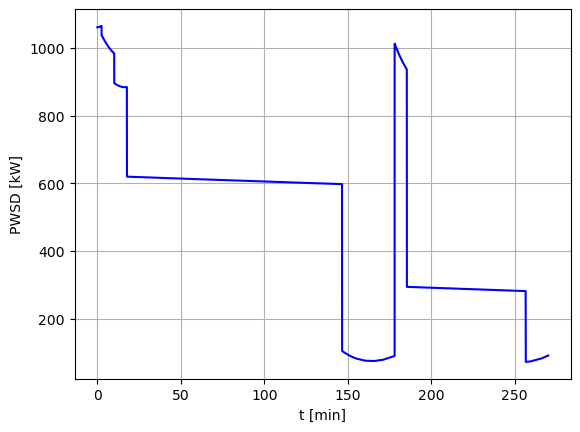

In [32]:
plt.plot(times/60,pwsd, 'b')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('PWSD [kW]')
plt.show()

potere calorifico: 43.5 MJ/kg


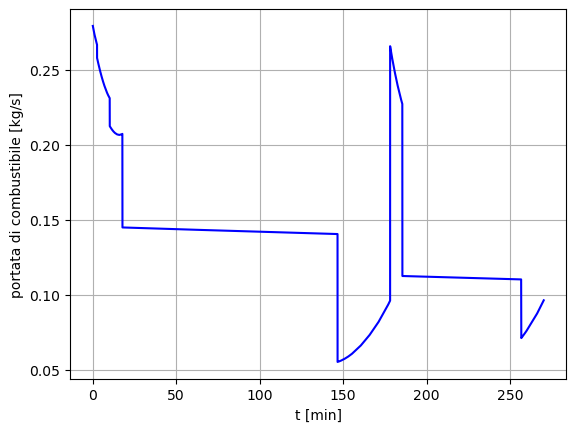

In [33]:
dEdt = np.zeros(len(times))
for t in range(len(times)):
    PP = (myaircraft.weight.WTO) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS')
    PRatio = myaircraft.powertrain.Traditional(myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.profile.Velocity(times[t]),PP)
    dEdt[t] = PP * PRatio[0]
print(f'potere calorifico: {myaircraft.weight.ef*1e-6} MJ/kg')
portata = dEdt/myaircraft.weight.ef
plt.plot(times/60,portata, 'b')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('portata di combustibile [kg/s]')
plt.show()

In [34]:
# identifico gli istanti temporali in cui termina una fase della missione e ne inizia un'altra
alt_cruise =MissionStages['Cruise']['input']['Altitude']
indici_quota_8000 = np.where(mission.profile.Altitude(times) == alt_cruise)
# print(indici_quota_8000[0])  # risultato: da 79 a 108
print(f'istante di inizio crociera: {times[indici_quota_8000[0][0]]/60} min')
print(f'istante di fine crociera: {times[indici_quota_8000[0][-1]]/60} min')
print('---------')

alt_iniziodiversione = DiversionStages['Climb1']['input']['StartAltitude']
# print(f'quota di inzio diversione: {alt_iniziodiversione} m')
indici_quota_200 = np.where(mission.profile.Altitude(times) == alt_iniziodiversione)
# print(indici_quota_200[0])  # ottengo [138 139]
print(f'istante di inizio diversione: {times[indici_quota_200[0][0]]/60} min')
print('---------')

alt_cruise2 = DiversionStages['Cruise']['input']['Altitude']
indici_quota_3100 = np.where(mission.profile.Altitude(times) == alt_cruise2)
# print(indici_quota_3100[0])  # risultato: da 155 a 178
print(f'istante di inizio Alternate cruise : {times[indici_quota_3100[0][0]]/60} min')
print(f'istante di fine Alternate cruise: {times[indici_quota_3100[0][-1]]/60} min')
print('---------')

print(f'DURATA DELLE FASI [min]')
print(f'Climb:\t\t\t{times[indici_quota_8000[0][0]]/60}')
print(f'Cruise:\t\t\t{times[indici_quota_8000[0][-1]]/60 - times[indici_quota_8000[0][0]]/60}')
print(f'Descent:\t\t{times[indici_quota_200[0][0]]/60 - times[indici_quota_8000[0][-1]]/60}')
print(f'Alternate Climb:\t{times[indici_quota_3100[0][0]]/60 - times[indici_quota_200[0][0]]/60}')
print(f'Alternate Cruise:\t{times[indici_quota_3100[0][-1]]/60 - times[indici_quota_3100[0][0]]/60}')
print(f'Alternate Descent:\t{times[-1]/60 - times[indici_quota_3100[0][-1]]/60}')
print(f'Tot:\t\t\t{times[-1]/60}')


istante di inizio crociera: 17.7 min
istante di fine crociera: 146.61666666666667 min
---------
istante di inizio diversione: 178.1 min
---------
istante di inizio Alternate cruise : 185.43333333333334 min
istante di fine Alternate cruise: 256.68333333333334 min
---------
DURATA DELLE FASI [min]
Climb:			17.7
Cruise:			128.91666666666669
Descent:		31.48333333333332
Alternate Climb:	7.333333333333343
Alternate Cruise:	71.25
Alternate Descent:	13.433333333333337
Tot:			270.1166666666667


In [35]:
from scipy.integrate import cumtrapz
# Calcolare l'integrale della portata rispetto al tempo
massa_di_fuel = cumtrapz(portata, times, initial=0.0)
# l'elemento n-esimo del vettore massa_di_fuel è l'integrale definito della portata tra t = 0 e t = times[n]
print(f'massa di combustibile necessaria per la missione: {massa_di_fuel[-1]} kg')
err = 100*abs(myaircraft.weight.Wf - massa_di_fuel[-1])/myaircraft.weight.Wf
print(f'questo valore differisce dall output originale del {err}%')

# ora la massa del block fuel (escludo la parte di diversione):
print(f'block fuel: {massa_di_fuel[indici_quota_200[0][0]]} kg')

# massa di fuel consumata durante la salita:
m_climb = massa_di_fuel[indici_quota_8000[0][0]]
print(f'Massa di combustibile impiegata per la salita: {m_climb} kg')

# massa di fuel consumata durante la crociera:
m_cruise = massa_di_fuel[indici_quota_8000[0][-1]] - massa_di_fuel[indici_quota_8000[0][0]]
print(f'Massa di combustibile impiegata per la crociera: {m_cruise} kg')

# massa di combustibile consumato durante la discesa:
m_descent =  massa_di_fuel[indici_quota_200[0][0]] - massa_di_fuel[indici_quota_8000[0][-1]]
print(f'Massa di combustibile impiegata per la discesa: {m_descent} kg')

print(type(indici_quota_8000[0][-1]))

massa di combustibile necessaria per la missione: 2133.515369375165 kg
questo valore differisce dall output originale del 0.011451500475933997%
block fuel: 1483.4974859720503 kg
Massa di combustibile impiegata per la salita: 246.54987788272632 kg
Massa di combustibile impiegata per la crociera: 1103.1851294915557 kg
Massa di combustibile impiegata per la discesa: 133.76247859776822 kg
<class 'numpy.int64'>


In [36]:
import os
import joblib
from sklearn.preprocessing import PolynomialFeatures
model = joblib.load('../PhlyGreen/ClimateImpact/EINOx_gasturb.joblib')

def EINOx_fun(pwsd, v0, alt):
    # Prepara i dati per la predizione
    data_for_prediction = np.array([[pwsd, v0, alt]])
    poly_features = PolynomialFeatures(degree=4)
    data_for_prediction_poly = poly_features.fit_transform(data_for_prediction)
    # Effettua la predizione
    EINOx = model.predict(data_for_prediction_poly)[0]

    return EINOx

print('EINOx medio (calcolato applicando la funzione alle medie di PWSD, v0 e alt):')
print(f'{EINOx_fun(mean_pwsd, mean_v0, mean_alt)}')

EINOx medio (calcolato applicando la funzione alle medie di PWSD, v0 e alt):
5.6661355799051325


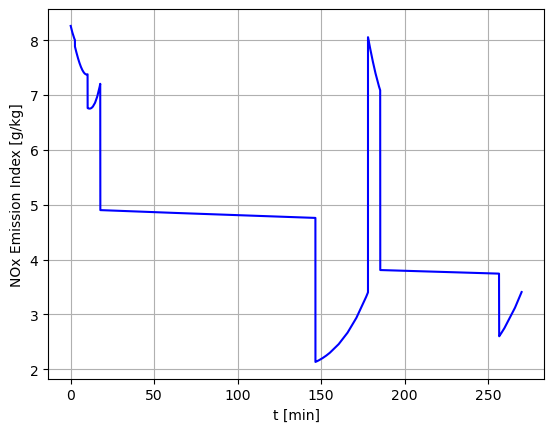

In [37]:
# valuto EINOx lungo la missione

EINOx = np.zeros(len(times))
for t in range(len(times)):
    EINOx[t]= EINOx_fun(pwsd[t], v0[t], alt[t])
plt.plot(times/60,EINOx, 'b')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('NOx Emission Index [g/kg]')
plt.show()


In [38]:
#  emissioni totali di NOx (tenendo conto di bruciare anche la riserva):
mean_EINOx = np.mean(EINOx)
print(f'EINOx medio durante la missione: {mean_EINOx} [g/kg]')
TotalFuel = myaircraft.weight.Wf + myaircraft.weight.final_reserve  # è 2196.6311676561495 kg
NOx = mean_EINOx*TotalFuel
print(f'NOx: {NOx} [g] (tenendo conto di bruciare anche la riserva)')

print('--------')
print('Napoli:')
NOx_n = 24.73*1000  # [g]
TotalFuel_n = 2260.9  # [kg]
mean_EINOx_n = NOx_n/TotalFuel_n
print(f'EINOx medio: {mean_EINOx_n} [g/kg]')
print(f'NOx: {NOx_n} [g]')

EINOx medio durante la missione: 5.787912564689054 [g/kg]
NOx: 13099.615108655325 [g] (tenendo conto di bruciare anche la riserva)
--------
Napoli:
EINOx medio: 10.938121986819407 [g/kg]
NOx: 24730.0 [g]


In [39]:
EINOx_climb = EINOx[0:indici_quota_8000[0][0]]
mean_EINOx_climb = np.mean(EINOx_climb)
EINOx_cruise = EINOx[indici_quota_8000[0][0]:indici_quota_8000[0][-1]+1]
mean_EINOx_cruise = np.mean(EINOx_cruise)
EINOx_descent = EINOx[indici_quota_8000[0][-1]+1:]
mean_EINOx_descent = np.mean(EINOx_descent)

# emissioni di NOx [g] durante le fasi della missione:

NOx_climb = mean_EINOx_climb * m_climb
NOx_cruise = mean_EINOx_cruise * m_cruise
NOx_descent = mean_EINOx_descent * m_descent

print(f'NOx climb: {NOx_climb} [g]')
print(f'NOx cruise: {NOx_cruise} [g]')
print(f'NOx descent: {NOx_descent} [g]')

NOx climb: 1895.7454438734044 [g]
NOx cruise: 5132.946620644069 [g]
NOx descent: 567.0380211397442 [g]


In [40]:
# Calcolare l'integrale della portata*EINOx rispetto al tempo
integranda = portata*EINOx
massa_di_NOx = cumtrapz(integranda, times, initial=0.0)
# l'elemento n-esimo del vettore massa_di_NOx è l'integrale definito dell'integranda tra t = 0 e t = times[n]
print(f'Emissione di NOx durante la missione: {massa_di_NOx[-1]} g')
print('(riserva non inclusa)')

Emissione di NOx durante la missione: 10314.448670758895 g
(riserva non inclusa)


In [41]:
# alcune distanze in metri 

print('Lunghezze salite e discesa: ',myaircraft.mission.profile.Distances)
print('Lunghezze salita e discesa (diversione): ',myaircraft.mission.profile.DistancesDiversion)
# i due vettori raccolgono le distanze orizzontali percorse durante le varie salite e discese
print('range di missione (diversione esclusa): ',myaircraft.mission.profile.MissionRange)
print('range diversione: ', myaircraft.mission.profile.DiversionRange)
# lunghezza delle crociere [m]:
l_cruise = myaircraft.mission.profile.MissionRange - np.sum(myaircraft.mission.profile.Distances)  
l_dcruise = myaircraft.mission.profile.DiversionRange - np.sum(myaircraft.mission.profile.DistancesDiversion)

TotalRange = myaircraft.mission.profile.MissionRange + myaircraft.mission.profile.DiversionRange

# distanze [m] dal punto di partenza alle quali cominciano le varie fasi di volo
d_2c = myaircraft.mission.profile.Distances[0]  # seconda salita (la prima comincia da 0)
d_3c = d_2c + myaircraft.mission.profile.Distances[1]  # terza salita
d_cruise = d_3c + myaircraft.mission.profile.Distances[2]  # crociera
d_d = d_cruise + l_cruise  # discesa
d_dc = d_d + myaircraft.mission.profile.Distances[3]  # salita (diversione)
d_dcruise = d_dc + myaircraft.mission.profile.DistancesDiversion[0]  # crociera (diversione)
d_dd = d_dcruise + l_dcruise  # discesa (diversione)
d = np.array([0, d_2c, d_3c, d_cruise, d_d, d_dc, d_dcruise, d_dd, TotalRange])
print(d)
qf = np.array([
    myaircraft.MissionStages['Climb1']['input']['StartAltitude'],
    myaircraft.MissionStages['Climb2']['input']['StartAltitude'],
    myaircraft.MissionStages['Climb3']['input']['StartAltitude'],
    myaircraft.MissionStages['Cruise']['input']['Altitude'],
    myaircraft.MissionStages['Descent1']['input']['StartAltitude'],
    myaircraft.DiversionStages['Climb1']['input']['StartAltitude'],
    myaircraft.DiversionStages['Cruise']['input']['Altitude'],
    myaircraft.DiversionStages['Descent1']['input']['StartAltitude'],
    myaircraft.DiversionStages['Descent1']['input']['EndAltitude']
])

print('lunghezze di break tra le fasi: ',qf)    
print('lunghezza crociera: ', l_cruise)
print('lunghezza crociera di diversione: ', l_dcruise)

Lunghezze salite e discesa:  [11704.0, 50050.0, 50050.0, 170010.0]
Lunghezze salita e discesa (diversione):  [48400.0, 72540.0]
range di missione (diversione esclusa):  1368750
range diversione:  401500
[      0.   11704.   61754.  111804. 1198740. 1368750. 1417150. 1697710.
 1770250.]
lunghezze di break tra le fasi:  [ 100 1500 4500 7000 7000  200 3100 3100  200]
lunghezza crociera:  1086936.0
lunghezza crociera di diversione:  280560.0
